In [22]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from numpy import logical_and as AND
from numpy import logical_or as OR
from numpy import logical_not as NOT
from pathlib import Path
from scipy.stats import pearsonr
from sklearn.metrics import matthews_corrcoef, mean_squared_error
from sklearn.linear_model import LogisticRegression
sns.set()
style.use('seaborn-poster')

In [2]:
## Files and directories.
SENTENCES = Path("./data/li-adger_sentences.csv")
MIN_PAIRS = Path("./data/li-adger_min_pairs.csv")

HUMAN_DATA = Path("./data/human_ME_results_li-adger_sentences.csv")
NGRAM_DATA = Path("./data/SYIFB2018/ngram.1.results.csv")
BERT_ACC_DATA = Path("./output/bert_acc_results_li-adger_sentences.csv")
BERT_MLM_DATA = Path("./output/bert_mlm_results_li-adger_sentences.csv")

# Load accrobatic sentences for later analyses...
BERT_LARGE_CASED_ACROBATIC_SENTS = Path("./output/bert-large-cased_acrobatic_sentences.csv")

OUTPUT_DIR = './output/li-adger_min_pairs_all_models.csv'


In [3]:
# Read the .csv files with minimal pairs and human judgements.
human_judgements = pd.read_csv(HUMAN_DATA)
min_pairs = pd.read_csv(MIN_PAIRS)

# Drop rows with values in the 'discard' column (this means they should be discarded from analysis).
min_pairs = min_pairs.loc[min_pairs.discard.isna()].reset_index(drop=True)
# Drop the 'discard' and 'notes' columns.
min_pairs.drop(labels=["discard", "notes"], axis=1, inplace=True)
# Drop incomplete minimal pairs (rows with NaN values).
min_pairs.dropna(axis=0, subset=["gramm_id", "gramm_sentence",
                                 "ungramm_id", "ungramm_sentence"], inplace=True)

# Load BERT data.
bert_acc_data = pd.read_csv(BERT_ACC_DATA, index_col=0)
bert_mlm_data = pd.read_csv(BERT_MLM_DATA, index_col=0)

# this section uses N-gram data from Sprouse et al. 2018.
ngram_data = pd.read_csv(NGRAM_DATA, skiprows=5, encoding="ISO-8859-1")
ngram_data = ngram_data.loc[OR(ngram_data["full.measure.name"] == "BNClogProb",
                               ngram_data["full.measure.name"] == "BNCslor")].reset_index(drop=True)



In [4]:
# Add the human judgements to the minimal pairs.
min_pairs = min_pairs.merge(human_judgements[["id", "judgement"]], how="left", 
                            left_on="gramm_id", right_on="id", validate="many_to_one")
min_pairs = min_pairs.drop(labels=["id"], axis=1).rename(columns={"judgement":"gramm_judgement"})

min_pairs = min_pairs.merge(human_judgements[["id", "judgement"]], how="left", 
                            left_on="ungramm_id", right_on="id", validate="many_to_one")
min_pairs = min_pairs.drop(labels=["id"], axis=1).rename(columns={"judgement":"ungramm_judgement"})


# Create column of human judgement deltas.
min_pairs["human_judge_delta"] = min_pairs.gramm_judgement - min_pairs.ungramm_judgement
# Creat a column of min-max normalized judgement deltas.
deltas = min_pairs.human_judge_delta
min_pairs["norm_human_judge_delta"] = (deltas - deltas.min())/(deltas.max() - deltas.min())

In [5]:
min_pairs

dataset  phenomenon             gramm_id  \
0         LI         NaN  32.1.martin.1a.g.01   
1         LI         NaN  32.1.martin.1a.g.02   
2         LI         NaN  32.1.martin.1a.g.03   
3         LI         NaN  32.1.martin.1a.g.04   
4         LI         NaN  32.1.martin.1a.g.05   
...      ...         ...                  ...   
2360   Adger         NaN       ch9.84-85.g.06   
2361   Adger         NaN       ch9.84-85.g.07   
2362   Adger         NaN       ch9.84-85.g.07   
2363   Adger         NaN       ch9.84-85.g.08   
2364   Adger         NaN       ch9.84-85.g.08   

                                     gramm_sentence           ungramm_id  \
0                 Kerry attempted to study physics.  32.1.martin.2c.*.01   
1                Jimmy attempted to weave a basket.  32.1.martin.2c.*.02   
2        Brittany attempted to touch the porcupine.  32.1.martin.2c.*.03   
3     Frank attempted to eat a triple fudge sundae.  32.1.martin.2c.*.04   
4                   Kat attempted to keep her mail.  32.1.martin.2c.*.05   
...                                             ...                  ...   
2360      I wondered what Dan cooked for breakfast.         ch9.105.*.06   
2361                   I wondered who Lisa married.       ch9.84-85.*.07   
2362                   I wondered who Lisa married.         ch9.105.*.07   
2363         I wondered where Katie went to school.       ch9.84-85.*.08   
2364         I wondered where Katie went to school.         ch9.105.*.08   

                                    ungramm_sentence  gramm_judgement  \
0                             Sarah saw pictures of.         1.467188   
1                              Jimmy saw baskets of.         1.290860   
2                        Brittany touched plenty of.         1.490671   
3                            Frank ate mountains of.         1.203261   
4                                  Kat kept tons of.         0.658771   
...                                              ...              ...   
2360  Jennifer thinks what Dan cooked for breakfast.         0.980632   
2361                  I wondered who did Lisa marry.         0.823930   
2362                  James thinks who Lisa married.         0.823930   
2363        I wondered where did Katie go to school.         1.306035   
2364         Eric thinks where Katie went to school.         1.306035   

      ungramm_judgement  human_judge_delta  norm_human_judge_delta  
0              -1.04705           2.514238                0.859317  
1              -0.95677           2.247630                0.791009  
2              -1.19339           2.684061                0.902827  
3              -0.83365           2.036911                0.737021  
4              -1.03173           1.690501                0.648267  
...                 ...                ...                     ...  
2360           -0.67550           1.656132                0.639461  
2361           -0.10862           0.932550                0.454072  
2362           -0.85522           1.679150                0.645359  
2363           -0.07672           1.382755                0.569419  
2364           -0.66823           1.974265                0.720970  

[2365 rows x 10 columns]

In [6]:
# Add the data from all the other models to the min_pairs dataframe.

## Add BERT acceptability data.
reduced_data = bert_acc_data.drop(labels=["sentence", "dataset", "notes", "typo?", "label"],
                                  axis="columns")
# Grammatical sentences.
min_pairs = min_pairs.merge(reduced_data, how="left", left_on="gramm_id", right_on="id",
                            validate="many_to_one")
min_pairs = min_pairs.drop(labels=["id"], axis=1)
# Ungrammatical sentences.
min_pairs = min_pairs.merge(reduced_data, how="left", left_on="ungramm_id", right_on="id",
                            validate="many_to_one", suffixes=("_gramm", "_ungramm"))
min_pairs = min_pairs.drop(labels=["id"], axis=1)


## Add BERT MLM data.
reduced_data = bert_mlm_data.drop(labels=["sentence", "dataset", "notes", "typo?", "sent_length"],
                                  axis="columns")
# Grammatical sentences.
min_pairs = min_pairs.merge(reduced_data, how="left", left_on="gramm_id", right_on="id",
                            validate="many_to_one")
min_pairs = min_pairs.drop(labels=["id"], axis=1)
# Ungrammatical sentences.
min_pairs = min_pairs.merge(reduced_data, how="left", left_on="ungramm_id", right_on="id",
                            validate="many_to_one", suffixes=("_gramm", "_ungramm"))
min_pairs = min_pairs.drop(labels=["id"], axis=1)
reduced_data = None

## Add ngram data.
# N-gram data needs a bit more work...
ngram_slor = ngram_data.loc[ngram_data.measure == "slor"].rename(columns={"probability":"slor"})
ngram_slor["slor_zscores"] = (ngram_slor.slor - ngram_slor.slor.mean())/ngram_slor.slor.std(ddof=0)
min_pairs = min_pairs.merge(ngram_slor[["id", "slor", "slor_zscores"]], left_on="gramm_id",
                            right_on="id", how="left", validate="many_to_one")
min_pairs = min_pairs.drop(labels=["id"], axis=1)
min_pairs = min_pairs.merge(ngram_slor[["id", "slor", "slor_zscores"]], left_on="ungramm_id",
                            right_on="id", how="left", validate="many_to_one",
                            suffixes=("_gramm", "_ungramm"))
min_pairs = min_pairs.drop(labels=["id"], axis=1)

ngram_logProb = ngram_data.loc[ngram_data.measure == "logProb"].rename(columns={"probability":"logProb"})
ngram_logProb["logProb_zscores"] = (ngram_logProb.logProb - ngram_logProb.logProb.mean())/ngram_logProb.logProb.std(ddof=0)
min_pairs = min_pairs.merge(ngram_logProb[["id", "logProb", "logProb_zscores"]], left_on="gramm_id",
                            right_on="id", how="left", validate="many_to_one")
min_pairs = min_pairs.drop(labels=["id"], axis=1)
min_pairs = min_pairs.merge(ngram_logProb[["id", "logProb", "logProb_zscores"]], left_on="ungramm_id",
                            right_on="id", how="left", validate="many_to_one",
                            suffixes=("_gramm", "_ungramm"))
min_pairs = min_pairs.drop(labels=["id"], axis=1)

# Cleanup.
ngram_slor, ngram_logProb = None, None


In [7]:
min_pairs.columns

Index(['dataset', 'phenomenon', 'gramm_id', 'gramm_sentence', 'ungramm_id',
       'ungramm_sentence', 'gramm_judgement', 'ungramm_judgement',
       'human_judge_delta', 'norm_human_judge_delta',
       'bert-base-uncased_acc_gramm', 'bert-base-uncased_acc_zscores_gramm',
       'bert-large-uncased_acc_gramm', 'bert-large-uncased_acc_zscores_gramm',
       'bert-large-cased_acc_gramm', 'bert-large-cased_acc_zscores_gramm',
       'bert-base-uncased_acc_ungramm',
       'bert-base-uncased_acc_zscores_ungramm',
       'bert-large-uncased_acc_ungramm',
       'bert-large-uncased_acc_zscores_ungramm',
       'bert-large-cased_acc_ungramm', 'bert-large-cased_acc_zscores_ungramm',
       'bert-base-uncased_mlm_gramm', 'bert-base-uncased_mlm_zscores_gramm',
       'bert-large-uncased_mlm_gramm', 'bert-large-uncased_mlm_zscores_gramm',
       'bert-large-cased_mlm_gramm', 'bert-large-cased_mlm_zscores_gramm',
       'bert-base-uncased_mlm_ungramm',
       'bert-base-uncased_mlm_zscores_ungram

In [8]:
# list of all the measurements under consideration (except human judgements).
measures = ["bert-base-uncased_acc", "bert-large-uncased_acc",
            "bert-large-cased_acc", "bert-base-uncased_mlm",
            "bert-large-uncased_mlm", "bert-large-cased_mlm", 
            "slor", "logProb"]

# Calculate the deltas.
for measure in measures:
    col_name = measure + "_zscore-delta"
    min_pairs[col_name] = min_pairs[measure + "_zscores_gramm"] - min_pairs[measure + "_zscores_ungramm"]
    

In [77]:
# Export the full min_pairs dataframe.
#min_pairs.to_csv(OUTPUT_DIR, index=False)

In [78]:
# Export subset of minimal pairs where SLOR does not meet the BLIMP condition.
#min_pairs.loc[min_pairs["slor_gramm"] < min_pairs["slor_ungramm"]].to_csv('./output/min_pairs_non_ngram.csv')

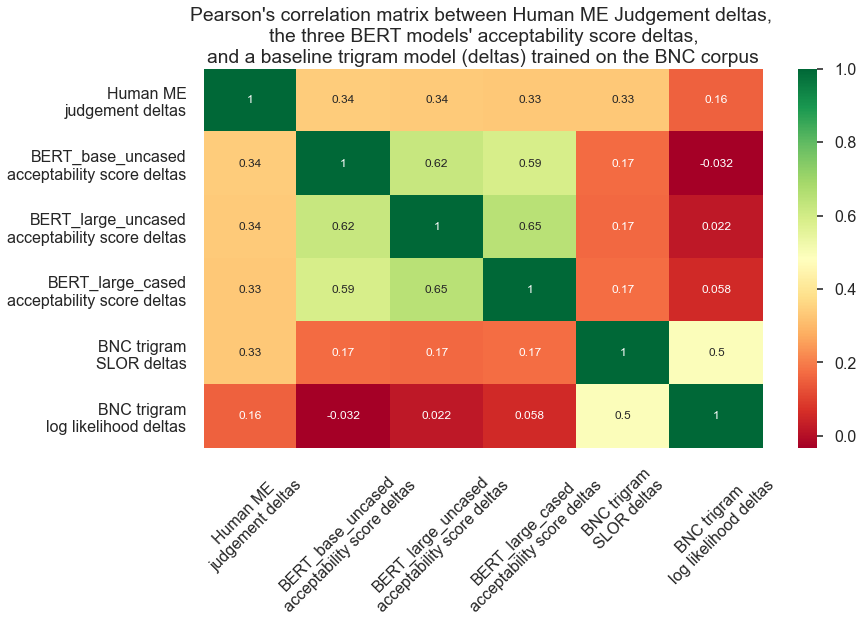

In [82]:
## Plot correlation coefficient matrix without BERT MLM data.

# list of metrics under consideration (except human judgements).
acc_measures = ["human_judge_delta",
                "bert-base-uncased_acc_zscore-delta",
                "bert-large-uncased_acc_zscore-delta",
                "bert-large-cased_acc_zscore-delta", 
                "slor_zscore-delta", "logProb_zscore-delta"]
corr_df = min_pairs[acc_measures].corr()

labels = ["Human ME\njudgement deltas", 
          "BERT_base_uncased\nacceptability score deltas",
          "BERT_large_uncased\nacceptability score deltas",
          "BERT_large_cased\nacceptability score deltas",
          "BNC trigram\nSLOR deltas", "BNC trigram\nlog likelihood deltas"]

fig, ax = plt.subplots()


sns.heatmap(corr_df, annot=True, cmap="RdYlGn", xticklabels=labels, yticklabels=labels, ax=ax)

for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.title("Pearson's correlation matrix between Human ME Judgement deltas, \n" +\
          "the three BERT models' acceptability score deltas,\n" +\
          "and a baseline trigram model (deltas) trained on the BNC corpus")
plt.tight_layout()
plt.savefig("./figures/bert_acc_delta_correlation_matrix.png")
plt.show()


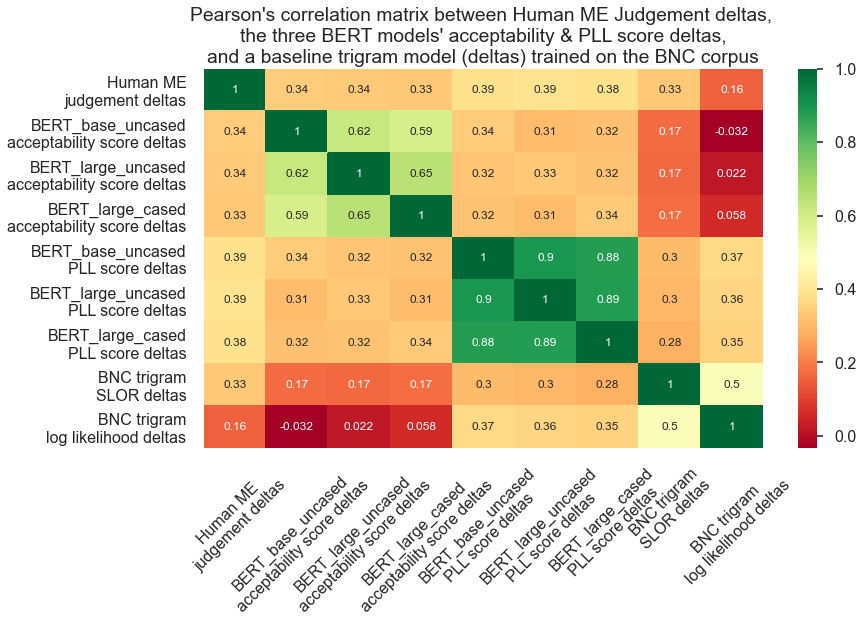

In [81]:
## Plot correlation coefficient matrix with all measures.
all_delta_measures = ["human_judge_delta",
                      "bert-base-uncased_acc_zscore-delta",
                      "bert-large-uncased_acc_zscore-delta",
                      "bert-large-cased_acc_zscore-delta", 
                      "bert-base-uncased_mlm_zscore-delta",
                      "bert-large-uncased_mlm_zscore-delta",
                      "bert-large-cased_mlm_zscore-delta",
                      "slor_zscore-delta", "logProb_zscore-delta"]

corr_df = min_pairs[all_delta_measures].corr()

labels = ["Human ME\njudgement deltas", 
          "BERT_base_uncased\nacceptability score deltas",
          "BERT_large_uncased\nacceptability score deltas",
          "BERT_large_cased\nacceptability score deltas",
          "BERT_base_uncased\nPLL score deltas",
          "BERT_large_uncased\nPLL score deltas",
          "BERT_large_cased\nPLL score deltas",
          "BNC trigram\nSLOR deltas", 
          "BNC trigram\nlog likelihood deltas"]

fig, ax = plt.subplots()


sns.heatmap(corr_df, annot=True, cmap="RdYlGn", xticklabels=labels, yticklabels=labels, ax=ax)

for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.title("Pearson's correlation matrix between Human ME Judgement deltas, \n" +\
          "the three BERT models' acceptability & PLL score deltas,\n" +\
          "and a baseline trigram model (deltas) trained on the BNC corpus")
plt.tight_layout()
plt.savefig("./figures/bert_acc_pll_delta_correlation_matrix.png")
plt.show()

<---------- bert-base-uncased_acc_zscore-delta vs human_judge_delta ---------->
PEARSON R SCORES:
All sentences:  (0.34019120410699105, 3.7330526728319993e-65)
LI sentences: (0.3406825006516734, 2.720816044882207e-33)
Adger sentences: (0.2759666621405842, 2.9311037541546575e-22)
MEAN SQUARE ERROR SCORES:
All sentences: 1.1546243276395023
LI sentences: 1.1990212529291706
Adger sentences: 1.110861111610896
<---------- bert-large-uncased_acc_zscore-delta vs human_judge_delta ---------->
PEARSON R SCORES:
All sentences:  (0.33804383856630316, 2.6255543146239e-64)
LI sentences: (0.3836175229327786, 1.8579791578898176e-42)
Adger sentences: (0.211043944030486, 1.8571470015161264e-13)
MEAN SQUARE ERROR SCORES:
All sentences: 1.1254856261725814
LI sentences: 1.1585781963724784
Adger sentences: 1.0928654100393498
<---------- bert-large-cased_acc_zscore-delta vs human_judge_delta ---------->
PEARSON R SCORES:
All sentences:  (0.3346055060760932, 5.777348710991249e-63)
LI sentences: (0.34936374029

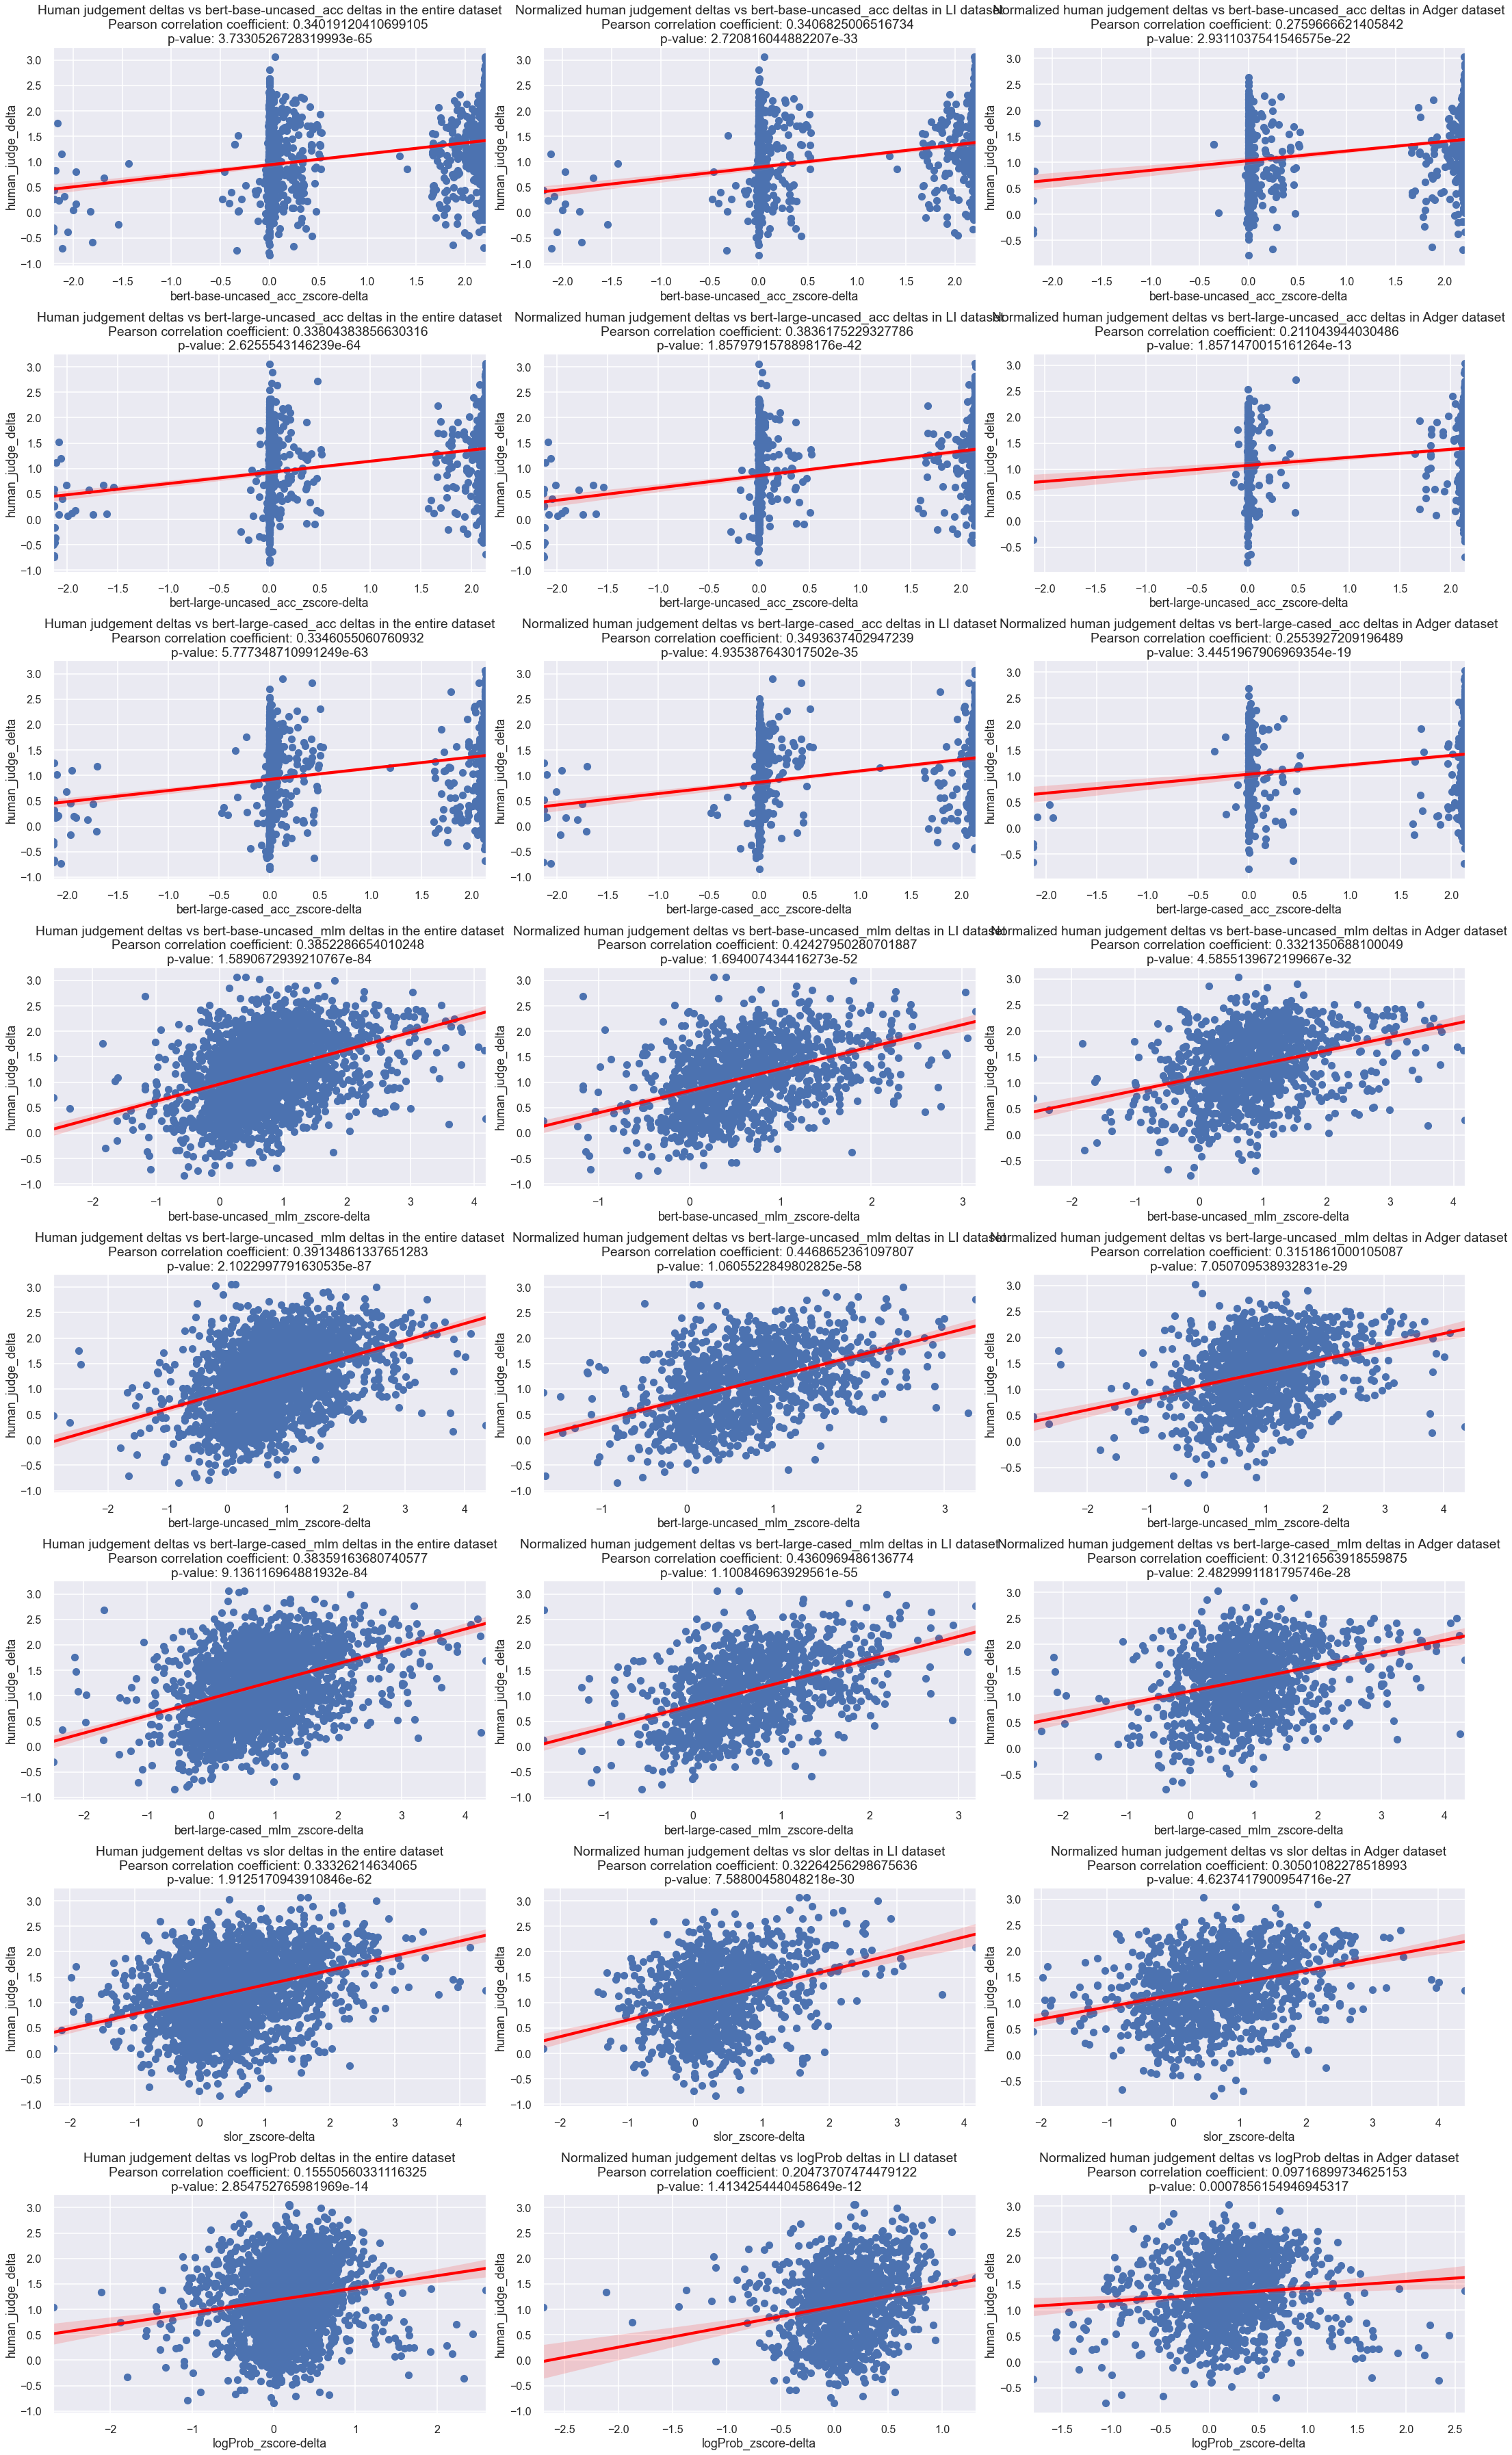

In [9]:

fig, axes = plt.subplots(nrows=len(measures), ncols=3, figsize=(30, 50))

idx = 0 # to keep track of the axis for plotting.
for measure in measures:
    li_data = min_pairs.loc[min_pairs.dataset == "LI"]
    adger_data = min_pairs.loc[min_pairs.dataset == "Adger"]
    # Variable names to plot with seaborn.
    
    # First column.
    y0 = "human_judge_delta"
    x0 = measure + "_zscore-delta"
    
    # Seaborn scatterplot with regression line.
    sns.regplot(x=x0, y=y0, data=min_pairs, ax=axes[idx, 0],
               scatter_kws={"alpha":1}, line_kws={"color":"red"})
    sns.regplot(x=x0, y=y0, data=li_data, ax=axes[idx, 1],
               scatter_kws={"alpha":1}, line_kws={"color":"red"})
    sns.regplot(x=x0, y=y0, data=adger_data, ax=axes[idx, 2],
               scatter_kws={"alpha":1}, line_kws={"color":"red"})
    
    # Correlation coefficients and p-values for title.
    cc0, pvalue0 = pearsonr(min_pairs[x0], min_pairs[y0])
    cc1, pvalue1 = pearsonr(li_data[x0], li_data[y0])
    cc2, pvalue2 = pearsonr(adger_data[x0], adger_data[y0])

    print("<----------", x0, "vs", y0, "---------->")
    print("PEARSON R SCORES:")
    print("All sentences: ", (cc0, pvalue0))
    print("LI sentences:", (cc1, pvalue1))
    print("Adger sentences:", (cc2, pvalue2))
    print("MEAN SQUARE ERROR SCORES:")
    print("All sentences:", mean_squared_error(min_pairs[y0], min_pairs[x0]))
    print("LI sentences:", mean_squared_error(li_data[y0], li_data[x0]))
    print("Adger sentences:", mean_squared_error(adger_data[y0], adger_data[x0]))
    # Titles.
    axes[idx, 0].set_title("Human judgement deltas vs {} deltas in the entire dataset\n".format(measure) +\
                           "Pearson correlation coefficient: {} \n".format(cc0) +\
                           "p-value: {}".format(pvalue0))
    axes[idx, 1].set_title("Normalized human judgement deltas vs {} deltas in LI dataset\n".format(measure) +\
                           "Pearson correlation coefficient: {} \n".format(cc1) +\
                           "p-value: {}".format(pvalue1))
    axes[idx, 2].set_title("Normalized human judgement deltas vs {} deltas in Adger dataset\n".format(measure) +\
                           "Pearson correlation coefficient: {} \n".format(cc2) +\
                           "p-value: {}".format(pvalue2))    
    # Increment axis counter.
    idx += 1

plt.tight_layout()
#plt.savefig("./output/all_three_regularized/model_deltas.jpg")
plt.show()

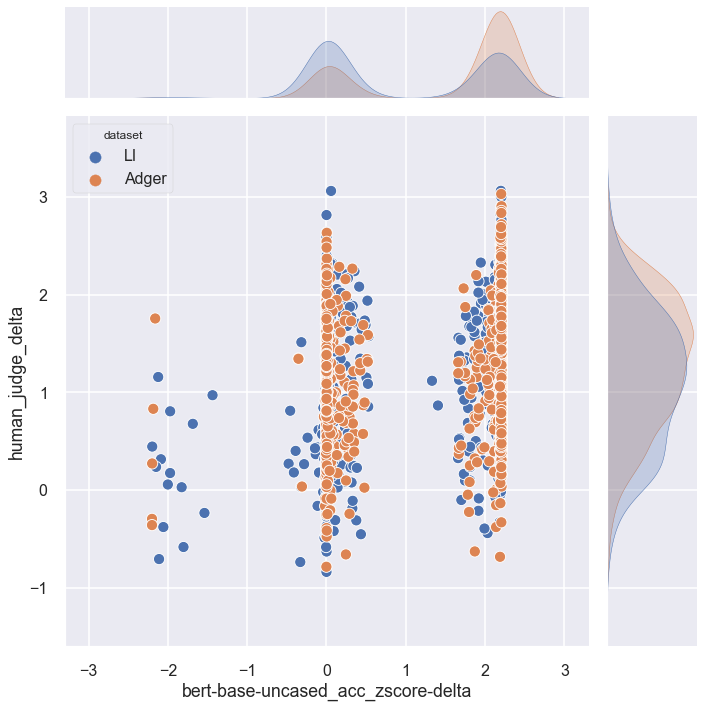

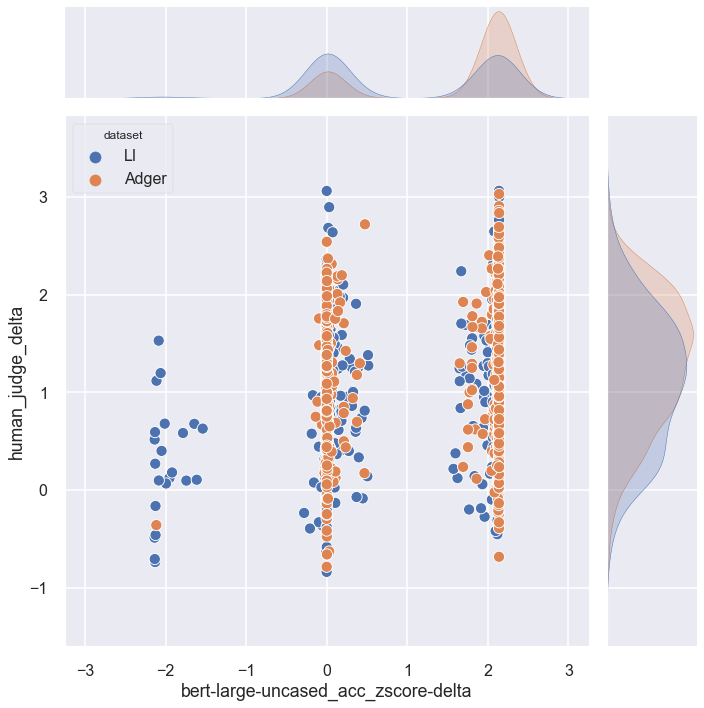

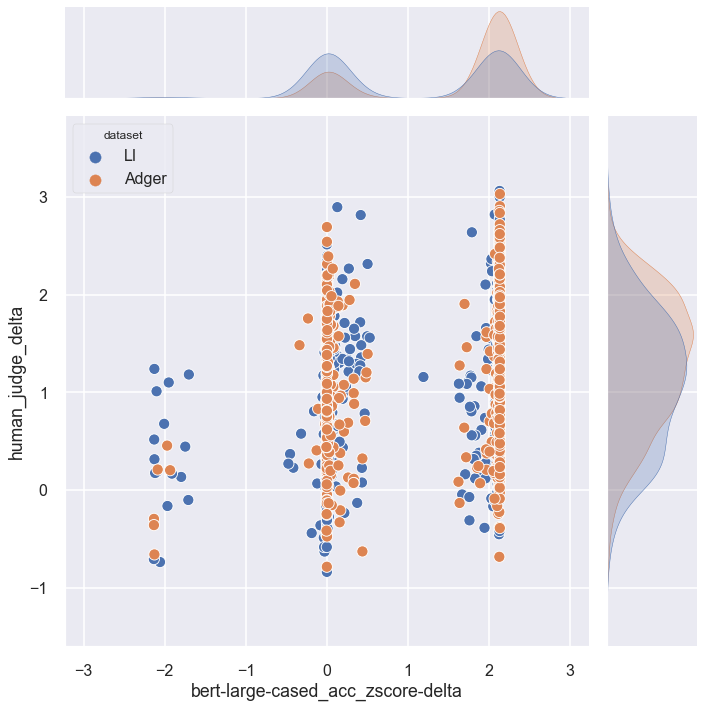

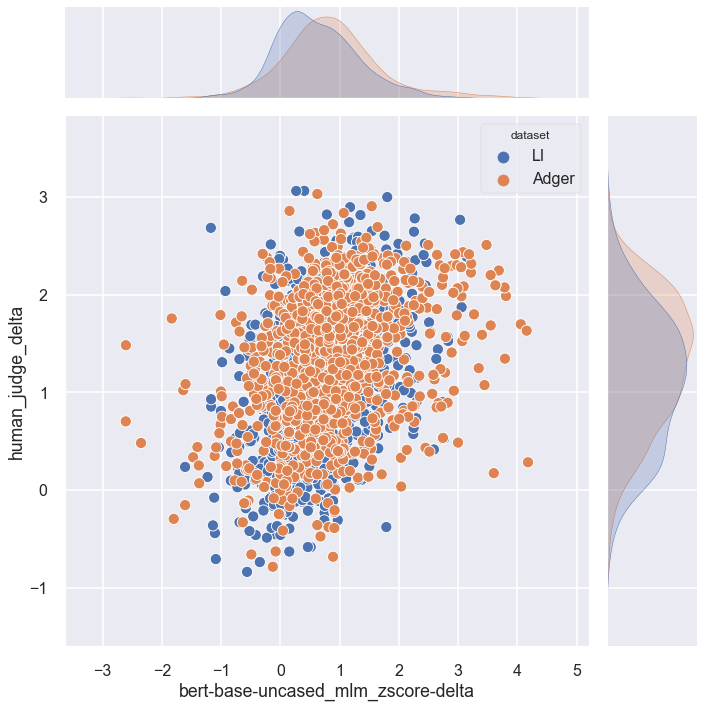

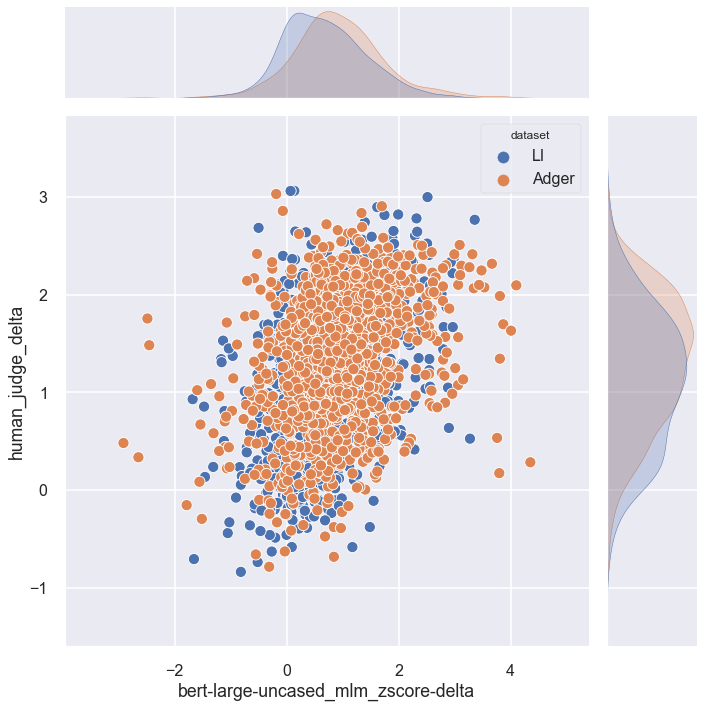

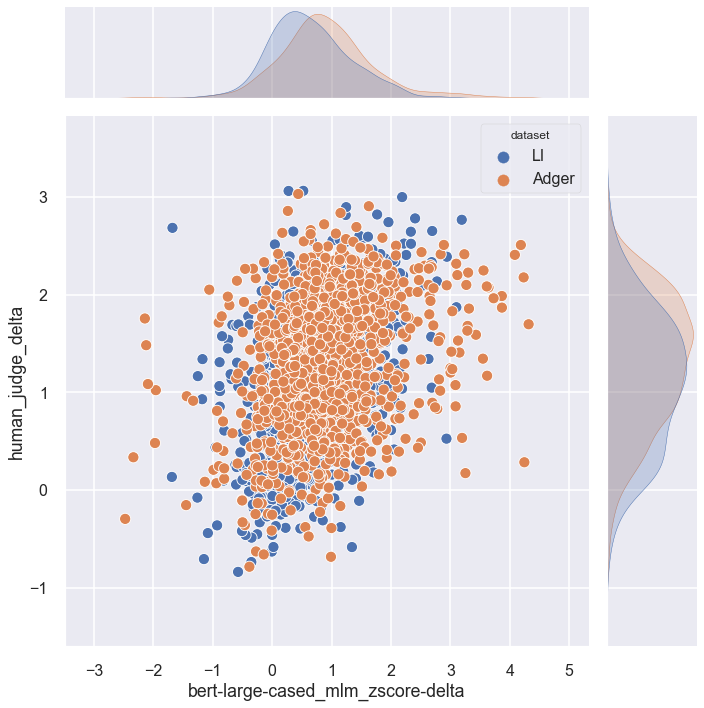

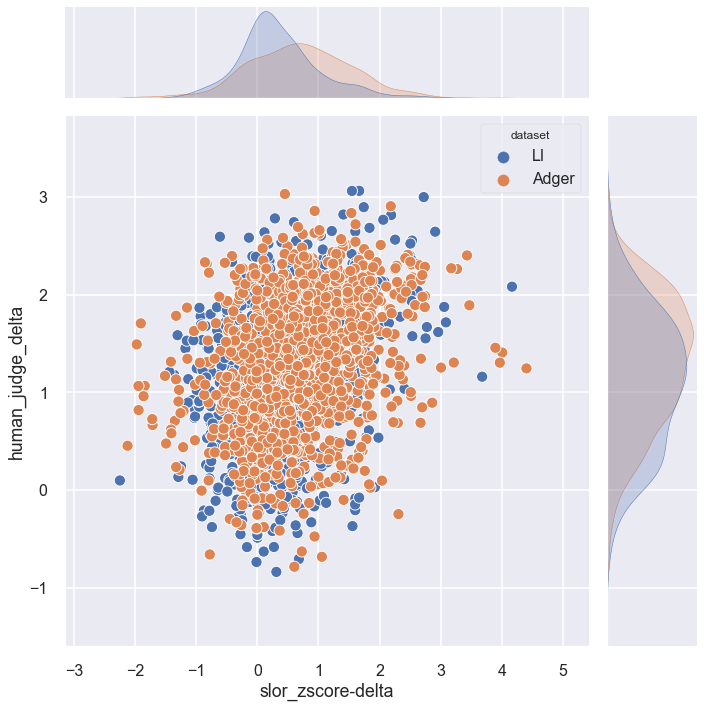

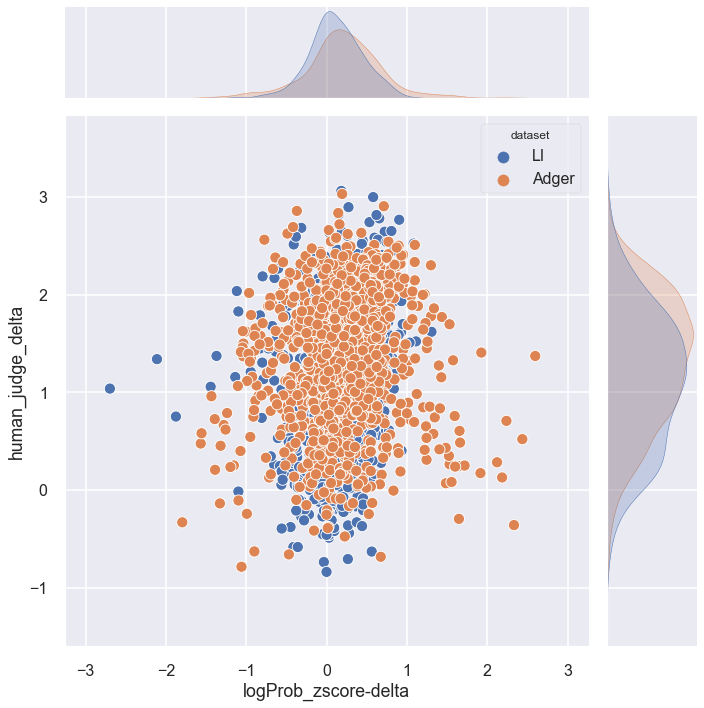

In [10]:
# Repeat the process above but with jointplots to show point density.
for measure in measures:
    y0 = "human_judge_delta"
    x0 = measure + "_zscore-delta"
    
    # Seaborn scatterplot with density plot.
    sns.jointplot(x=x0, y=y0, hue="dataset", data=min_pairs, height=10)

<---------- bert-base-uncased_acc_zscore-delta vs logProb_zscore-delta ---------->
| PEARSON R SCORES: (-0.03216296677551054, 0.11788723707858946) |
| MEAN SQUARE ERROR SCORES: 2.627671560445643 |
<---------- bert-base-uncased_acc_zscore-delta vs slor_zscore-delta ---------->
| PEARSON R SCORES: (0.17051333388908926, 6.878072809169736e-17) |
| MEAN SQUARE ERROR SCORES: 2.058296089548391 |
---------------------------------------------------------------------------
<---------- bert-large-uncased_acc_zscore-delta vs logProb_zscore-delta ---------->
| PEARSON R SCORES: (0.021913234819849938, 0.2867705677136655) |
| MEAN SQUARE ERROR SCORES: 2.6359521514293673 |
<---------- bert-large-uncased_acc_zscore-delta vs slor_zscore-delta ---------->
| PEARSON R SCORES: (0.16747190003663706, 2.443656545012992e-16) |
| MEAN SQUARE ERROR SCORES: 2.093021608913084 |
---------------------------------------------------------------------------
<---------- bert-large-cased_acc_zscore-delta vs logProb_zscor

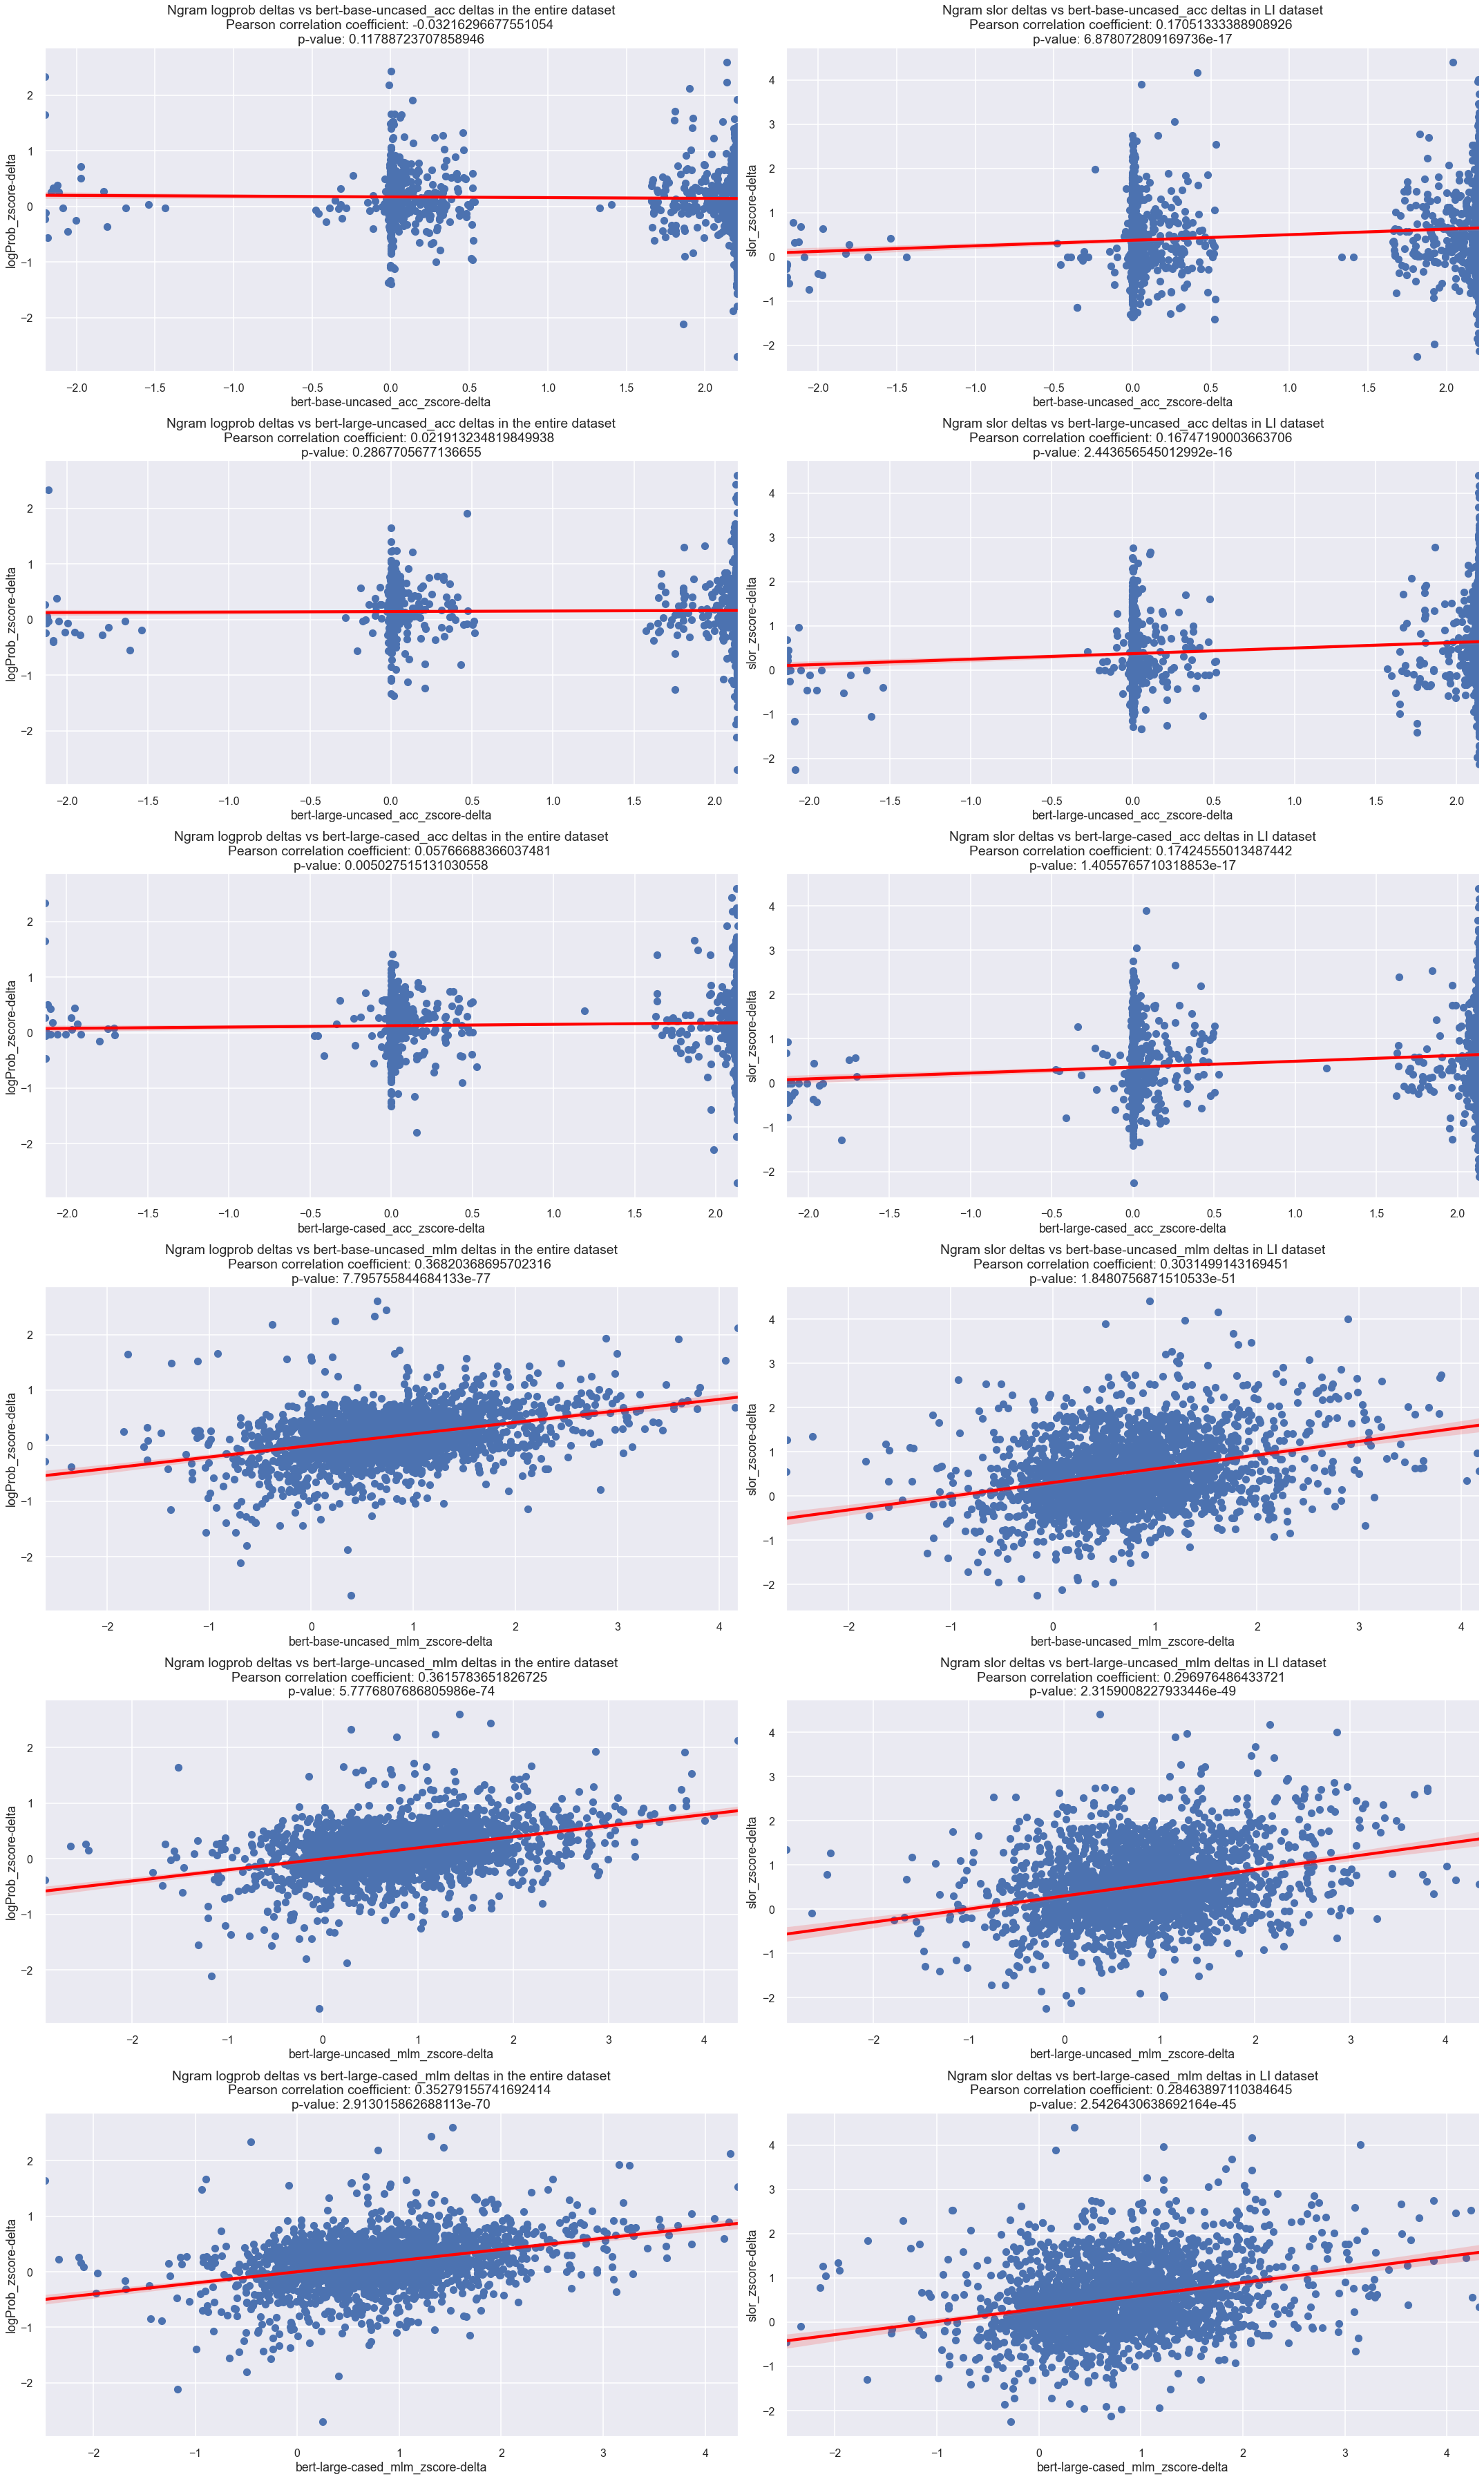

In [11]:
# What happens if we plot BERT data against N-gram data?

fig, axes = plt.subplots(nrows=len(measures) - 2, ncols=2, figsize=(30, 50))

idx = 0 # to keep track of the axis for plotting.
for measure in measures:
    # Variable names to plot with seaborn.
    if measure in ["slor", "logProb"]: continue # Skip Ngram measures...
    
    # First column.
    y0 = "logProb_zscore-delta"
    x0 = measure + "_zscore-delta"
    
    # Second column.
    y1 = "slor_zscore-delta"
    x1 = measure + "_zscore-delta"
    
    # Seaborn scatterplot with regression line.
    sns.regplot(x=x0, y=y0, data=min_pairs, ax=axes[idx, 0],
               scatter_kws={"alpha":1}, line_kws={"color":"red"})
    sns.regplot(x=x1, y=y1, data=min_pairs, ax=axes[idx, 1],
               scatter_kws={"alpha":1}, line_kws={"color":"red"})
    
    # Correlation coefficients and p-values for title.
    cc0, pvalue0 = pearsonr(min_pairs[x0], min_pairs[y0])
    cc1, pvalue1 = pearsonr(min_pairs[x1], min_pairs[y1])

    print("<----------", x0, "vs", y0, "---------->")
    print("| PEARSON R SCORES:", (cc0, pvalue0), "|")
    print("| MEAN SQUARE ERROR SCORES:", mean_squared_error(min_pairs[y0], min_pairs[x0]), "|")
    print("<----------", x1, "vs", y1, "---------->")
    print("| PEARSON R SCORES:", (cc1, pvalue1), "|")
    print("| MEAN SQUARE ERROR SCORES:", mean_squared_error(min_pairs[y1], min_pairs[x1]), "|")
    print("---------------------------------------------------------------------------")
    
    # Titles.
    axes[idx, 0].set_title("Ngram logprob deltas vs {} deltas in the entire dataset\n".format(measure) +\
                           "Pearson correlation coefficient: {} \n".format(cc0) +\
                           "p-value: {}".format(pvalue0))
    axes[idx, 1].set_title("Ngram slor deltas vs {} deltas in LI dataset\n".format(measure) +\
                           "Pearson correlation coefficient: {} \n".format(cc1) +\
                           "p-value: {}".format(pvalue1)) 
    # Increment axis counter.
    idx += 1

plt.tight_layout()
#plt.savefig("./output/all_three_regularized/model_deltas.jpg")
plt.show()

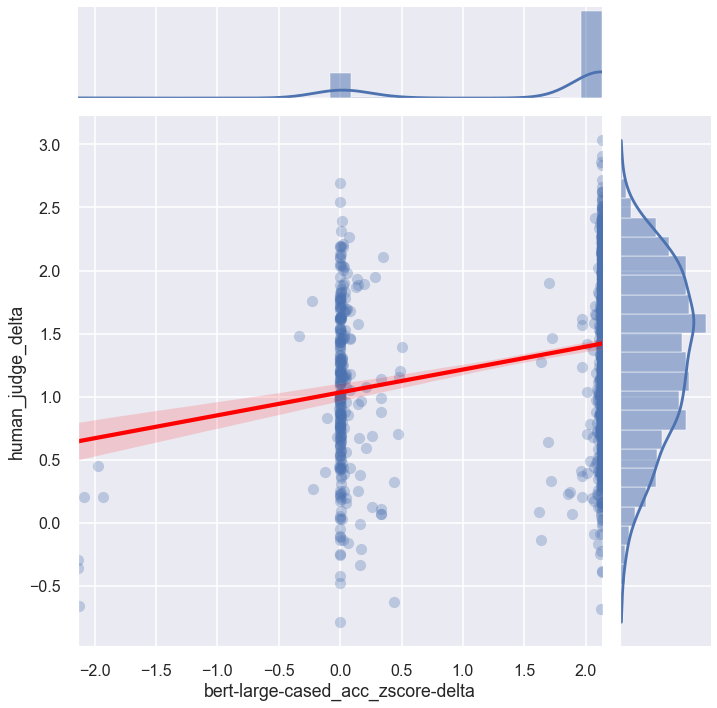

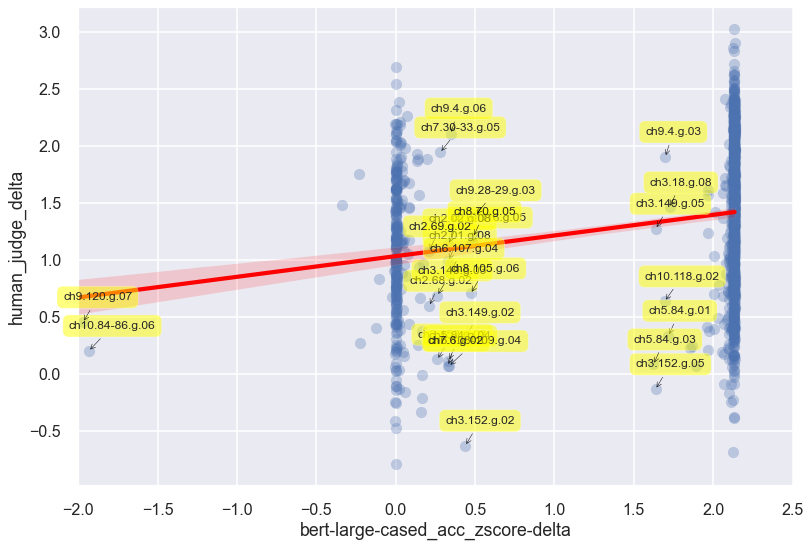

In [12]:
## Focus on BERT-large-cased performance on the Adger sentences.
plot = sns.jointplot(x="bert-large-cased_acc_zscore-delta", y="human_judge_delta", 
              data=min_pairs.loc[min_pairs.dataset == "Adger"], height=10, kind="reg",
             scatter_kws={"alpha":.3}, line_kws={"color":"red"}, marginal_kws={"bins":25})

fig, ax = plt.subplots()

sns.regplot(x="bert-large-cased_acc_zscore-delta", y="human_judge_delta",
              data=min_pairs.loc[min_pairs.dataset == "Adger"],
             scatter_kws={"alpha":.3}, line_kws={"color":"red"}, ax=ax)

for idx, row in min_pairs.loc[min_pairs.dataset == "Adger"].iterrows():
    #print(row)
    if OR(row["bert-large-cased_acc_zscore-delta"] < -0.5,
          AND(row["bert-large-cased_acc_zscore-delta"] < 1.8, row["bert-large-cased_acc_zscore-delta"] > 0.2)):
        ax.annotate(row["gramm_id"], 
                    xy=(row["bert-large-cased_acc_zscore-delta"], row["human_judge_delta"]),
                    xytext=(-20, 20),
                    textcoords="offset points", ha="left", va="bottom",
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0', color='black'))

ax.set_xlim(-2, 2.5)

plt.show()

In [92]:
# Make a new dataframe to analyze the best BERT model (bert-large-cased).
bert_large_cased = min_pairs[["gramm_id", "ungramm_id", 
                              "gramm_judgement", "ungramm_judgement", "human_judge_delta",
                              "bert-large-cased_acc_gramm", "bert-large-cased_acc_ungramm",
                              "bert-large-cased_acc_zscore-delta",
                              "bert-large-cased_mlm_gramm", "bert-large-cased_mlm_ungramm",
                              "bert-large-cased_mlm_zscore-delta"]].copy()
bert_large_cased["mlm_blimp_criterion"] = 1
bert_large_cased["mlm_delta_criterion"] = 1
bert_large_cased["acc_blimp_criterion"] = 1
bert_large_cased["acc_delta_criterion"] = 1

In [93]:
## Analyze the best BERT model (bert-large-cased).
'''Notes: I will be counting when BERT's judements are wrong according to the following conditions: 
Let H1 and H2 be the gramm/ungramm human min pair judgements.  And let B1, B2 be the corresponding
BERT acceptability judgements.

If the BERT minimal pair is not marked WRONG, it is CORRECT.

1. BLIMP CRITERION: IF( B1 < B2 ) THEN( BERT WRONG )
2. DELTA CRITERION: 
    2a. IF( OR( AND( H1 - H2 > 0, B1 - B2 < 0 ), AND( H1 - H2 < 0, B1 - B2 > 0 ) ) ) THEN( BERT WRONG )
    2b. IF( NOT( |(H1 - H2) - (B1 - B2)| < 0.5 ) ) THEN ( BERT WRONG )
'''
## BLiMP Criterion:
delta = 0.5

# BERT fine-tuned with CoLA
bert_large_cased.loc[bert_large_cased["bert-large-cased_acc_zscore-delta"] <= 0,
                     "acc_blimp_criterion"] = 0
# BERT MLM objective
bert_large_cased.loc[bert_large_cased["bert-large-cased_mlm_zscore-delta"] <= 0,
                     "mlm_blimp_criterion"] = 0

## Acceptability Delta Criterion:

# BERT fine-tuned with CoLA
bert_large_cased.loc[OR( AND( bert_large_cased.human_judge_delta <= 0,
                              bert_large_cased["bert-large-cased_acc_zscore-delta"] > 0),
                         AND( bert_large_cased.human_judge_delta > 0,
                              bert_large_cased["bert-large-cased_acc_zscore-delta"] <= 0)),
                     "acc_delta_criterion"] = 0
bert_large_cased.loc[NOT( np.abs(bert_large_cased.human_judge_delta - \
                                 bert_large_cased["bert-large-cased_acc_zscore-delta"]) < delta),
                     "acc_delta_criterion"] = 0

# BERT MLM objective
bert_large_cased.loc[OR( AND( bert_large_cased.human_judge_delta < 0,
                              bert_large_cased["bert-large-cased_mlm_zscore-delta"] > 0),
                         AND( bert_large_cased.human_judge_delta > 0,
                              bert_large_cased["bert-large-cased_mlm_zscore-delta"] < 0)),
                     "mlm_delta_criterion"] = 0
bert_large_cased.loc[NOT( np.abs(bert_large_cased.human_judge_delta - \
                                 bert_large_cased["bert-large-cased_mlm_zscore-delta"]) < delta),
                     "mlm_delta_criterion"] = 0


In [94]:
# Basic statistics on BERT large cased performance under both criteria.
print("BERT large cased BLiMP Criterion performance                |")
print("|-----------------------------------------------------------|")
print("| BERT fine-tuned with CoLA:")
print("| | Incorrect:", bert_large_cased.acc_blimp_criterion.value_counts()[0])
print("| | Correct:", bert_large_cased.acc_blimp_criterion.value_counts()[1])
print("| | Percentage:", bert_large_cased.acc_blimp_criterion.sum()/bert_large_cased.acc_blimp_criterion.shape[0])
print("|-----------------------------------------------------------|")
print("| BERT MLM objective:")
print("| | Incorrect:", bert_large_cased.mlm_blimp_criterion.value_counts()[0])
print("| | Correct:", bert_large_cased.mlm_blimp_criterion.value_counts()[1])
print("| | Percentage:", bert_large_cased.mlm_blimp_criterion.sum()/bert_large_cased.mlm_blimp_criterion.shape[0])
print("|-----------------------------------------------------------|")
print("BERT large cased Acceptability Delta Criterion performance  |")
print("|-----------------------------------------------------------|")
print("| BERT fine-tuned with CoLA:")
print("| | Incorrect:", bert_large_cased.acc_delta_criterion.value_counts()[0])
print("| | Correct:", bert_large_cased.acc_delta_criterion.value_counts()[1])
print("| | Percentage:", bert_large_cased.acc_delta_criterion.sum()/bert_large_cased.acc_blimp_criterion.shape[0])
print("|-----------------------------------------------------------|")
print("| BERT MLM objective:")
print("| | Incorrect:", bert_large_cased.mlm_delta_criterion.value_counts()[0])
print("| | Correct:", bert_large_cased.mlm_delta_criterion.value_counts()[1])
print("| | Percentage:", bert_large_cased.mlm_delta_criterion.sum()/bert_large_cased.mlm_blimp_criterion.shape[0])
print("|-----------------------------------------------------------|")

BERT large cased BLiMP Criterion performance                |
|-----------------------------------------------------------|
| BERT fine-tuned with CoLA:
| | Incorrect: 152
| | Correct: 2213
| | Percentage: 0.9357293868921776
|-----------------------------------------------------------|
| BERT MLM objective:
| | Incorrect: 304
| | Correct: 2061
| | Percentage: 0.8714587737843552
|-----------------------------------------------------------|
BERT large cased Acceptability Delta Criterion performance  |
|-----------------------------------------------------------|
| BERT fine-tuned with CoLA:
| | Incorrect: 1639
| | Correct: 726
| | Percentage: 0.30697674418604654
|-----------------------------------------------------------|
| BERT MLM objective:
| | Incorrect: 1475
| | Correct: 890
| | Percentage: 0.3763213530655391
|-----------------------------------------------------------|


In [61]:
# Make a new dataframe to analyze the N-gram model (SLOR & logProb).
ngram = min_pairs[["gramm_id", "ungramm_id", 
                   "gramm_judgement", "ungramm_judgement", "human_judge_delta",
                   "slor_gramm", "slor_ungramm", "slor_zscore-delta",
                   "logProb_gramm", "logProb_ungramm", "logProb_zscore-delta"]].copy()
ngram["logProb_blimp_criterion"] = 1
ngram["logProb_delta_criterion"] = 1
ngram["slor_blimp_criterion"] = 1
ngram["slor_delta_criterion"] = 1

In [62]:
# Analyze the ngram SLOR scores.
'''Notes: I will be counting when the N-gram model's judements are wrong according to 
the following conditions: 
Let H1 and H2 be the gramm/ungramm human min pair judgements.  And let N1, N2 be the corresponding
N-gram scores, which could be either SLOR or logProb scores.

If the N-gram minimal pair is not marked WRONG, it is CORRECT.

1. BLIMP CRITERION: IF( N1 < N2 ) THEN( N-GRAM WRONG )
2. DELTA CRITERION: 
    2a. IF( OR( AND( H1 - H2 > 0, N1 - N2 < 0 ), AND( H1 - H2 < 0, N1 - N2 > 0 ) ) ) THEN( N-GRAM WRONG )
    2b. IF( NOT( |(H1 - H2) - (N1 - N2)| < 0.5 ) ) THEN ( N-GRAM WRONG )
'''
## BLiMP Criterion:

# N-gram logProb
ngram.loc[ngram["logProb_zscore-delta"] <= 0,
                "logProb_blimp_criterion"] = 0
# N-gram SLOR
ngram.loc[ngram["slor_zscore-delta"] <= 0,
                "slor_blimp_criterion"] = 0

## Acceptability Delta Criterion:

# N-gram logProb
ngram.loc[OR( AND( ngram.human_judge_delta <= 0,
                   ngram["logProb_zscore-delta"] > 0),
              AND( ngram.human_judge_delta > 0,
                   ngram["logProb_zscore-delta"] <= 0)),
          "logProb_delta_criterion"] = 0
ngram.loc[NOT( np.abs(ngram.human_judge_delta - \
                      ngram["logProb_zscore-delta"]) < 0.5),
          "logProb_delta_criterion"] = 0

# N-gram SLOR
ngram.loc[OR( AND( ngram.human_judge_delta < 0,
                   ngram["slor_zscore-delta"] > 0),
              AND( ngram.human_judge_delta > 0,
                   ngram["slor_zscore-delta"] < 0)),
          "slor_delta_criterion"] = 0
ngram.loc[NOT( np.abs(ngram.human_judge_delta - \
                      ngram["slor_zscore-delta"]) < 0.5),
          "slor_delta_criterion"] = 0


In [63]:
# Basic statistics on N-gram performance under both criteria.
print("N-gram BLiMP Criterion performance                |")
print("|-----------------------------------------------------------|")
print("| N-gram logProb:")
print("| | Incorrect:", ngram.logProb_blimp_criterion.value_counts()[0])
print("| | Correct:", ngram.logProb_blimp_criterion.value_counts()[1])
print("| | Percentage:", ngram.logProb_blimp_criterion.sum()/ngram.logProb_blimp_criterion.shape[0])
print("|-----------------------------------------------------------|")
print("| N-gram SLOR:")
print("| | Incorrect:", ngram.slor_blimp_criterion.value_counts()[0])
print("| | Correct:", ngram.slor_blimp_criterion.value_counts()[1])
print("| | Percentage:", ngram.slor_blimp_criterion.sum()/ngram.slor_blimp_criterion.shape[0])
print("|-----------------------------------------------------------|")
print("N-gram Acceptability Delta Criterion performance  |")
print("|-----------------------------------------------------------|")
print("| N-gram logProb:")
print("| | Incorrect:", ngram.logProb_delta_criterion.value_counts()[0])
print("| | Correct:", ngram.logProb_delta_criterion.value_counts()[1])
print("| | Percentage:", ngram.logProb_delta_criterion.sum()/ngram.logProb_delta_criterion.shape[0])
print("|-----------------------------------------------------------|")
print("| N-gram SLOR:")
print("| | Incorrect:", ngram.slor_delta_criterion.value_counts()[0])
print("| | Correct:", ngram.slor_delta_criterion.value_counts()[1])
print("| | Percentage:", ngram.slor_delta_criterion.sum()/ngram.slor_delta_criterion.shape[0])
print("|-----------------------------------------------------------|")

N-gram BLiMP Criterion performance                |
|-----------------------------------------------------------|
| N-gram logProb:
| | Incorrect: 779
| | Correct: 1586
| | Percentage: 0.6706131078224101
|-----------------------------------------------------------|
| N-gram SLOR:
| | Incorrect: 584
| | Correct: 1781
| | Percentage: 0.7530655391120508
|-----------------------------------------------------------|
N-gram Acceptability Delta Criterion performance  |
|-----------------------------------------------------------|
| N-gram logProb:
| | Incorrect: 1975
| | Correct: 390
| | Percentage: 0.1649048625792812
|-----------------------------------------------------------|
| N-gram SLOR:
| | Incorrect: 1653
| | Correct: 712
| | Percentage: 0.3010570824524313
|-----------------------------------------------------------|


In [352]:
# Verify when BERT's predictions and SLOR scores agree.
'''Notes: I will be counting when BERT's acceptability scores and the ngram's SLOR scores 
are agree on a given minimal pair according to the following rule: 
Let B1 and B2 be the gramm/ungramm BERT min pair judgements.  And let S1, S2 be the corresponding
ngram SLOR scores.

If the ngram SLOR minimal pair is not marked WRONG, it is CORRECT.

1. IF( OR( AND( B1 > B2, S1 > S2 ), AND( B1 < B2, S1 < S2 ) ) ) THEN( AGREEMENT )
'''
min_pairs["bert-slor_agreement"] = ""

# Condition 1: Monotonicity
min_pairs.loc[OR( AND( min_pairs["bert-large-cased_delta"] > 0,
                       min_pairs.slor_delta > 0),
                  AND( min_pairs["bert-large-cased_delta"] < 0,
                       min_pairs.slor_delta < 0)),
              "bert-slor_agreement"] = "X"

# Condition 5: DELTA TEST!
min_pairs.loc[AND( min_pairs.norm_slor_delta <= 0.3,
                   min_pairs["norm_bert-large-cased_delta"] <= 0.3),
              "bert-slor_agreement"] += "D"

min_pairs.loc[AND( AND( min_pairs.norm_slor_delta > 0.3,
                        min_pairs.norm_slor_delta <= 0.7),
                   AND( min_pairs["norm_bert-large-cased_delta"] > 0.3,
                        min_pairs["norm_bert-large-cased_delta"] <= 0.7) ),
              "bert-slor_agreement"] += "D"
min_pairs.loc[AND( min_pairs.norm_slor_delta > 0.7,
                   min_pairs["norm_bert-large-cased_delta"] > 0.7),
              "bert-slor_agreement"] += "D"

In [350]:
# Separate the minimal pairs into acrobatic and non-acrobatic pairs.

# Load the acrobatic_sentences for bert-large-cased.
acrobatic_sentences = pd.read_csv(BERT_LARGE_CASED_ACC_SENTS, index_col=0)
acrobatic_sentences["flips"] = 1

# Columns of interest on the acrobatic_sentences.
acrobatic_cols = ['bert-large-cased_wrong', 'ngram-slor_wrong', 'bert-slor_agreement',
                  'dataset', 'gramm_id', 'ungramm_id', 'gramm_sentence', 'ungramm_sentence',
                  'gramm_judgement', 'ungramm_judgement', 'human_judge_delta', 'norm_human_judge_delta',
                  'gramm_bert-large-cased', 'ungramm_bert-large-cased', 'bert-large-cased_delta',
                  'norm_bert-large-cased_delta']

# Get minimal pairs where bert-large-cased flips.
acrobatic_pairs = min_pairs.loc[OR(min_pairs.gramm_id.isin(acrobatic_sentences.id),
                                   min_pairs.ungramm_id.isin(acrobatic_sentences.id))].copy()
acrobatic_pairs = acrobatic_pairs[acrobatic_cols]

unathletic_pairs = min_pairs.loc[~OR(min_pairs.gramm_id.isin(acrobatic_sentences.id),
                                     min_pairs.ungramm_id.isin(acrobatic_sentences.id))].copy()
unathletic_pairs = unathletic_pairs[acrobatic_cols]

# Output these separately for furhter analysis on Excel...
acrobatic_pairs.loc[acrobatic_pairs["bert-large-cased_wrong"] != ""].to_csv("./output/all_three_regularized/bert_large_cased_wrong_acrobatic_pairs.csv", index=False)
acrobatic_pairs.loc[acrobatic_pairs["bert-large-cased_wrong"] == ""].to_csv("./output/all_three_regularized/bert_large_cased_correct_acrobatic_pairs.csv", index=False)
unathletic_pairs.loc[unathletic_pairs["bert-large-cased_wrong"] != ""].to_csv("./output/all_three_regularized/bert_large_cased_wrong_unathletic_pairs.csv", index=False)
unathletic_pairs.loc[unathletic_pairs["bert-large-cased_wrong"] == ""].to_csv("./output/all_three_regularized/bert_large_cased_correct_unathletic_pairs.csv", index=False)



In [353]:
min_pairs.to_csv(OUTPUT_DIR, index=False)

In [264]:
# Gather some statistics regarding BERT vs. N-gram SLOR.

# Number of minimal pairs SLOR ordered correctly (S1 > S2).
print("SLOR correctly ordered (S1 > S2) {}/{} minimal pairs".format(
                min_pairs.loc[~(min_pairs["ngram-slor_wrong"] == "X")].shape[0],
                min_pairs.shape[0]))

# Number of minimal pairs correctly labeled by BERT (B1 > 0, B2 < 0)
print("BERT large cased correctly labeled (B1 > 0, B2 < 0) {}/{} minimal pairs".format(
                min_pairs.loc[~OR( AND( min_pairs.gramm_judgement > 0,
                                        min_pairs["gramm_bert-large-cased"] < 0),
                                   AND( min_pairs.ungramm_judgement < 0,
                                        min_pairs["ungramm_bert-large-cased"] > 0))].shape[0],
                min_pairs.shape[0]))

# Number of minimal pairs where BERT and SLOR agree:
print("BERT large cased and SLOR agree on {}/{} minimal pairs".format(
                min_pairs.loc[min_pairs["bert-slor_agreement"] == "X"].shape[0],
                min_pairs.shape[0]))



SLOR correctly ordered (S1 > S2) 1346/1958 minimal pairs
BERT large cased correctly labeled (B1 > 0, B2 < 0) 1407/1958 minimal pairs
BERT large cased and SLOR agree on 1365/1958 minimal pairs


dataset              gramm_id            ungramm_id  \
24      LI  32.1.martin.66a.g.02  32.1.martin.66b.*.02   
40      LI  32.1.martin.92b.g.02  32.1.martin.93b.*.02   
42      LI  32.1.martin.92b.g.04  32.1.martin.93b.*.04   
44      LI  32.1.martin.92b.g.06  32.1.martin.93b.*.06   
45      LI  32.1.martin.92b.g.07  32.1.martin.93b.*.07   

                                       gramm_sentence  \
24             It is not wise for one to skip class .   
40         Linda is certain to have passed the test .   
42     Maria is bound to have finished her homework .   
44                Kelsey appears to have left early .   
45  Dylan seems to have written the computer progr...   

                                     ungramm_sentence  gramm_judgement  \
24                 It is not wise one to skip class .         1.107860   
40               Linda is possible to pass the test .         0.978042   
42        Maria is important to finish her homework .         0.695012   
44              Kelsey was attempted to leave early .         0.993561   
45  Dylan was planned to write the computer program .         1.034716   

    ungramm_judgement  human_judge_delta  norm_human_judge_delta  \
24          -0.563523           1.671383                0.647567   
40          -0.789600           1.767642                0.672518   
42          -1.126396           1.821408                0.686455   
44          -0.858319           1.851880                0.694354   
45          -0.538895           1.573611                0.622223   

    gramm_bert-base-uncased  ...  ungramm_slor  slor_delta  norm_slor_delta  \
24                 0.997167  ...      0.787572   -0.009098         0.343288   
40                 0.997400  ...      0.677697   -0.105985         0.297078   
42                 0.997577  ...      0.710606   -0.047562         0.324942   
44                 0.997515  ...      0.682495   -0.168415         0.267303   
45                 0.997673  ...      0.779637   -0.058862         0.319553   

    gramm_logProb  ungramm_logProb  logProb_delta  norm_logProb_delta  \
24     -24.425447       -22.488853      -1.936593            0.262543   
40     -23.871557       -20.607222      -3.264334            0.220874   
42     -24.953070       -22.281613      -2.671457            0.239480   
44     -20.056847       -19.532535      -0.524312            0.306866   
45     -23.608769       -23.587511      -0.021258            0.322654   

    bert-large-cased_wrong  ngram-slor_wrong  bert-slor_agreement  
24                                         X                       
40                                         X                       
42                                         X                       
44                                         X                       
45                                         X                       

[5 rows x 32 columns]

In [268]:
delta_test = pd.DataFrame(data=[], columns=min_pairs.columns)
delta_test = delta_test.append(min_pairs.loc[AND( min_pairs.norm_human_judge_delta <= 0.3,
                                 (min_pairs["norm_bert-large-cased_delta"] <= 0.3))].copy())
delta_test = delta_test.append(min_pairs.loc[AND( AND( min_pairs.norm_human_judge_delta > 0.3,
                                                       min_pairs.norm_human_judge_delta <= 0.7),
                                                 AND( min_pairs["norm_bert-large-cased_delta"] > 0.3,
                                                       min_pairs["norm_bert-large-cased_delta"] <= 0.7)
                                                )].copy())
delta_test = delta_test.append(min_pairs.loc[AND( min_pairs.norm_human_judge_delta > 0.7,
                                 (min_pairs["norm_bert-large-cased_delta"] > 0.7))].copy())
delta_test.shape

(868, 32)

In [269]:
delta_test = pd.DataFrame(data=[], columns=min_pairs.columns)
delta_test = delta_test.append(min_pairs.loc[AND( min_pairs.norm_human_judge_delta <= 0.3,
                                 (min_pairs["norm_slor_delta"] <= 0.3))].copy())
delta_test = delta_test.append(min_pairs.loc[AND( AND( min_pairs.norm_human_judge_delta > 0.3,
                                                       min_pairs.norm_human_judge_delta <= 0.7),
                                                 AND( min_pairs["norm_slor_delta"] > 0.3,
                                                       min_pairs["norm_slor_delta"] <= 0.7)
                                                )].copy())
delta_test = delta_test.append(min_pairs.loc[AND( min_pairs.norm_human_judge_delta > 0.7,
                                 (min_pairs["norm_slor_delta"] > 0.7))].copy())
delta_test.shape

(1201, 32)